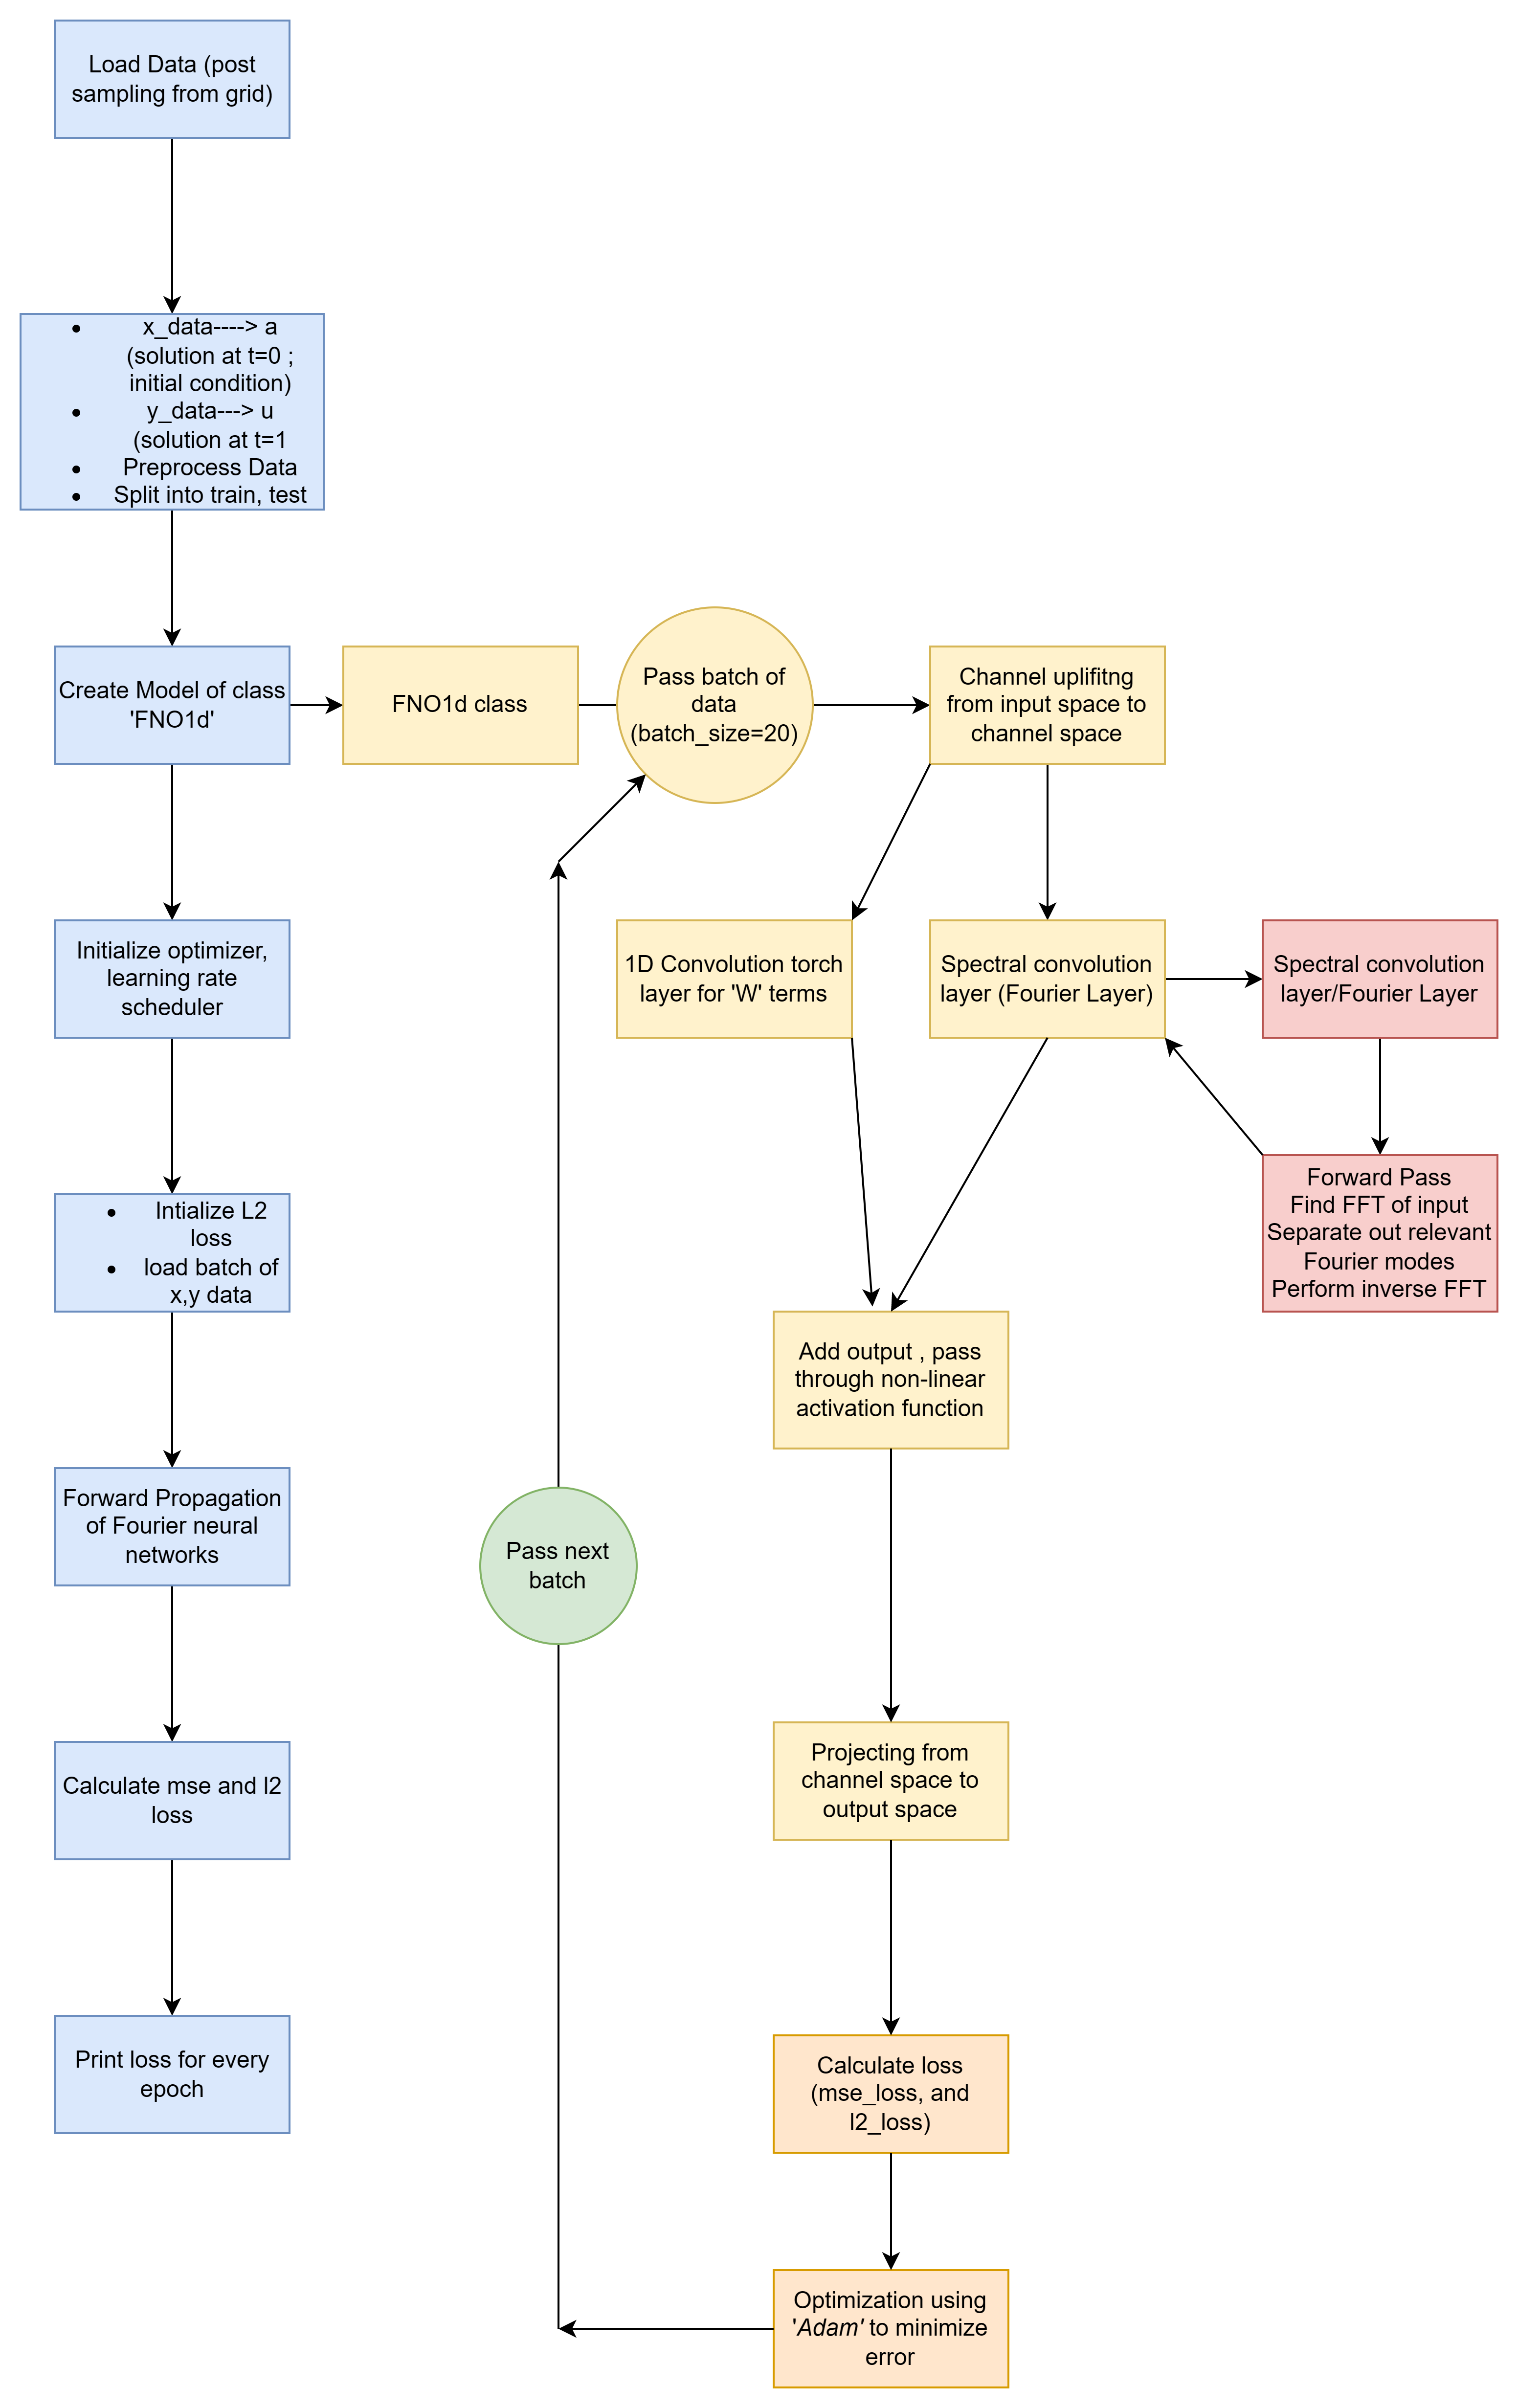

In [20]:
"""

This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import scipy
import operator
from functools import reduce
from functools import partial
from timeit import default_timer


import matplotlib.pyplot as plt


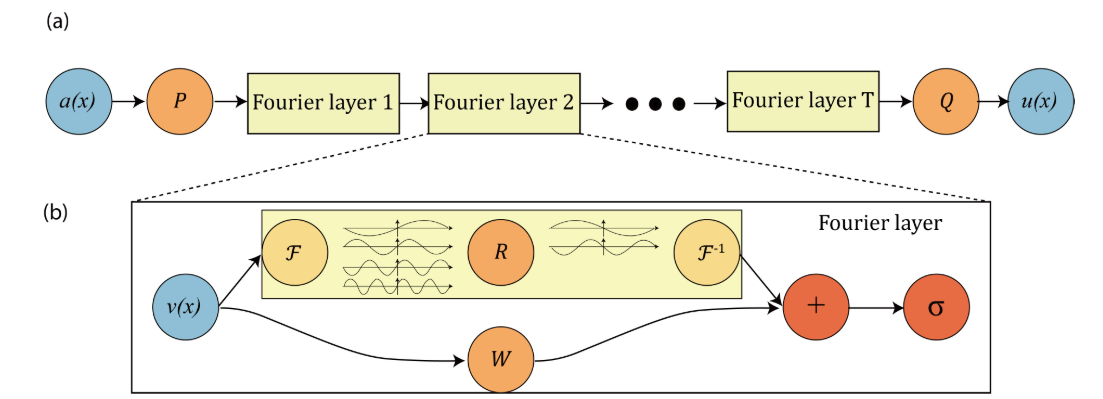

In [21]:
################################################################
#  1d fourier layer
################################################################

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))           #use the scaling factor to initialise complex weights of dimensions [in_channels, out_channels, modes]

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        #do a complex multiplication of the form written above with truncated fourier modes and weights to do linear transformation 'R'
        #HINT : use 'torch.einsum'
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #HINT : you can use a torch function to do a fft of a real valued input 'x' so that output contains only positive frequencies
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1) #call compl_mul1d function to enable linear transformation of selected modes and complex weights initiated above
        #print(out_ft)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))   #do an inverse fft of out_ft to shift from fourier space to real space using torch function
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2
        self.fc0 =  nn.Linear(2, self.width) # input channel is 2: (a(x), x); uplift from 2 features to 64 features using torch linear neural network

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.w0 =    nn.Conv1d(self.width, self.width, 1)                            #bias term parallel to fourier layer of size (w), that do a 1D convolution
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 =  nn.Linear(self.width, 128)                              #project from channel width to a 128 layer neural network (width, 128)
        self.fc2 = nn.Linear(128, 1)                              #project from a 128 layer neural network to a single output neuron (128,1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)   #input now contains (a(x), x)
        x = self.fc0(x)                               #call fc0 layer initiated above to shift from 2 to 64 
        x = x.permute(0, 2, 1)   #permute layers to change order to allow for fft and linear transformation of x from (0,1,2)----> (0,2,1)
        

        x1 = self.conv0(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w0(x)                        #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =   F.gelu(x)                       #pass through activation 'gelu'

        x1 = self.conv1(x)                        #consecutively pass through spectral convolution and bias convolution layer
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2


        x = x.permute(0, 2, 1)     #permute back to original shape 
        x = self.fc1(x)                       #uplift from channel width to 128 layer network
        x =  F.gelu(x)                       #pass through activation gelu
        x = self.fc2(x)                       #shift to real space
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



In [22]:
class LpLoss(object):
    def __init__(self, p=2):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert p > 0
        self.p = p



    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(torch.flatten(x, -1) - torch.flatten(y, -1), \
                          p=self.p, dim=-1, keepdim=False) #calculate norm between ground truth and predicted truth making sure their dimensions are compatible
        y_norms =torch.norm(torch.flatten(y, -1), p=self.p, dim=-1, keepdim=False) #calculate norm of ground truth


        return torch.sum(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

In [26]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.0001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = scipy.io.loadmat('burgers_data_R10.mat')
x_data = dataloader['a'][:,::sub]
y_data = dataloader['u'][:,::sub]
x_data= x_data.astype(np.float32)
x_data= torch.from_numpy(x_data)
y_data= y_data.astype(np.float32)
y_data= torch.from_numpy(y_data)
x_train = torch.tensor(x_data[:ntrain,:], requires_grad=True, dtype=torch.float32)
y_train = torch.tensor(y_data[:ntrain,:], requires_grad=True, dtype=torch.float32)
x_test = torch.tensor(x_data[-ntest:,:], requires_grad=False, dtype=torch.float32)
y_test = torch.tensor(y_data[-ntest:,:], requires_grad=False, dtype=torch.float32)

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c
# model
model = FNO1d(modes, width)
print(count_params(model))


################################################################
# training and evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)       #use Adam optimizer from torch with appropriate arguments 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size,gamma)       # use a learning rate scheduler
train_mseList=[]
train_l2List=[]
myloss =LpLoss(p=2)  #initialise Lploss class object to calculate 'L2-norm'
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)
        mse = torch.nn.MSELoss()
        mse = mse(out[:,:,0],y)#calculate mse loss between forward pass of network and y data by reshaping out and y to be of compatible shapes
        l2 =myloss.rel(out[:,:,0],y)  #calculate L2-loss by calling the 'rel' function defined Lploss class
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        train_mseList.append(train_mse)
        train_l2List.append(train_l2)

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:

            out = model(x)
            l2 =myloss.rel(out[:,:,0],y)
            test_l2 += l2 #calculate test L2 loss

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest


    print(ep, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')



C:\Users\najka\AppData\Local\Temp\ipykernel_14436\2973837976.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_data[:ntrain,:], requires_grad=True, dtype=torch.float32)
C:\Users\najka\AppData\Local\Temp\ipykernel_14436\2973837976.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_data[:ntrain,:], requires_grad=True, dtype=torch.float32)
C:\Users\najka\AppData\Local\Temp\ipykernel_14436\2973837976.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_data[-ntest:

549569
0 0.215798529535532 0.937812045097351 tensor(0.7047)
1 0.033537909174337986 0.30071934819221496 tensor(0.1492)
2 0.00534839308122173 0.10170977091789246 tensor(0.0653)
3 0.0021187728497898206 0.05261526268720627 tensor(0.0432)
4 0.0012970833128201776 0.03744378370046616 tensor(0.0324)
5 0.0009500546759227291 0.030354230046272277 tensor(0.0282)
6 0.0007817258887371281 0.026723299086093902 tensor(0.0255)
7 0.0006401302485755878 0.023395749866962433 tensor(0.0217)
8 0.000532675306458259 0.02088451910018921 tensor(0.0188)
9 0.0004557068086069194 0.01843478316068649 tensor(0.0173)
10 0.00037668176715669686 0.016823656648397446 tensor(0.0172)
11 0.0003291764857567614 0.01541074226796627 tensor(0.0157)
12 0.0002743423227184394 0.014231230169534682 tensor(0.0140)
13 0.00024328637522557983 0.013334194615483285 tensor(0.0126)
14 0.00021702779311453925 0.012974101036787034 tensor(0.0124)
15 0.00019795453659753547 0.01166996456682682 tensor(0.0110)
16 0.0001722036018873041 0.011019753560423

133 1.44023291341e-05 0.002972966555505991 tensor(0.0031)
134 1.4698418930265688e-05 0.0030992215275764466 tensor(0.0033)
135 1.4145678667318862e-05 0.0030732108168303966 tensor(0.0030)
136 1.4222569291177933e-05 0.0029721610583364963 tensor(0.0031)
137 1.4076384255758967e-05 0.003007737908512354 tensor(0.0030)
138 1.4082334653267026e-05 0.0029335139580070973 tensor(0.0028)
139 1.4099566921004224e-05 0.0030423064790666104 tensor(0.0029)
140 1.4011087311018855e-05 0.003008652746677399 tensor(0.0029)
141 1.385526471153753e-05 0.0029353312849998473 tensor(0.0029)
142 1.3684473011608133e-05 0.002944625549018383 tensor(0.0029)
143 1.3619562603253143e-05 0.0029906287975609304 tensor(0.0029)
144 1.3483153576316909e-05 0.002904510796070099 tensor(0.0029)
145 1.3491425374922982e-05 0.0029016541615128517 tensor(0.0030)
146 1.3577588877069502e-05 0.002946144990622997 tensor(0.0028)
147 1.3237984952638725e-05 0.0029425647035241126 tensor(0.0028)
148 1.3395481306588409e-05 0.002916517399251461 tens

263 1.0195642246344506e-05 0.0023593872003257275 tensor(0.0024)
264 1.0204877656860845e-05 0.002370828356593847 tensor(0.0024)
265 1.0176768395808721e-05 0.0023593080788850782 tensor(0.0024)
266 1.0171635780125144e-05 0.002354072790592909 tensor(0.0024)
267 1.0163431977048276e-05 0.0023524643257260324 tensor(0.0024)
268 1.0101468297989414e-05 0.00235113737359643 tensor(0.0024)
269 1.0195830893167112e-05 0.002358140330761671 tensor(0.0024)
270 1.01763556727974e-05 0.0023466477245092394 tensor(0.0024)
271 1.0171433619348135e-05 0.0023528839536011217 tensor(0.0024)
272 1.0129163257488472e-05 0.0023486408963799476 tensor(0.0024)
273 1.0151063004286697e-05 0.0023476756550371647 tensor(0.0024)
274 1.0104966107746805e-05 0.002345489725470543 tensor(0.0024)
275 1.0073696290646695e-05 0.002343413243070245 tensor(0.0024)
276 1.015361224631306e-05 0.0023542986400425436 tensor(0.0024)
277 1.0028903064380756e-05 0.002340001840144396 tensor(0.0024)
278 1.0086194549785432e-05 0.002342330219224095 ten

KeyboardInterrupt: 